<a href="https://colab.research.google.com/github/naralakamsani/unsupervised_learning/blob/main/reservation_retention_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
from google.colab import drive

from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier

from scipy.stats import kurtosis
from sklearn.metrics import classification_report, f1_score, silhouette_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

import time

#Data

[Hotel Reservation](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?select=Hotel+Reservations.csv)


##Load Data

In [2]:
!curl -o Hotel_Reservations.csv https://raw.githubusercontent.com/naralakamsani/supervised_learning/main/data/reservation_retention/Hotel%20Reservations.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3164k  100 3164k    0     0  8013k      0 --:--:-- --:--:-- --:--:-- 8011k


In [3]:
df = pd.read_csv("Hotel_Reservations.csv")

In [4]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Encode Labeled Data

In [5]:
df = df.drop(columns=["Booking_ID"])

df['booking_status'].replace('Not_Canceled', 0, inplace=True)
df['booking_status'].replace('Canceled', 1, inplace=True)

df['type_of_meal_plan'].replace('Not Selected', 0, inplace=True)
df['type_of_meal_plan'].replace('Meal Plan 1', 1, inplace=True)
df['type_of_meal_plan'].replace('Meal Plan 2', 2, inplace=True)
df['type_of_meal_plan'].replace('Meal Plan 3', 3, inplace=True)

df['room_type_reserved'].replace('Room_Type 1', 1, inplace=True)
df['room_type_reserved'].replace('Room_Type 2', 2, inplace=True)
df['room_type_reserved'].replace('Room_Type 3', 3, inplace=True)
df['room_type_reserved'].replace('Room_Type 4', 4, inplace=True)
df['room_type_reserved'].replace('Room_Type 5', 5, inplace=True)
df['room_type_reserved'].replace('Room_Type 6', 6, inplace=True)
df['room_type_reserved'].replace('Room_Type 7', 7, inplace=True)

df['market_segment_type'].replace('Offline', 0, inplace=True)
df['market_segment_type'].replace('Online', 1, inplace=True)
df['market_segment_type'].replace('Corporate', 2, inplace=True)
df['market_segment_type'].replace('Aviation', 3, inplace=True)
df['market_segment_type'].replace('Complementary', 4, inplace=True)

In [6]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,1,0,1,224,2017,10,2,0,0,0,0,65.00,0,0
1,2,0,2,3,0,0,1,5,2018,11,6,1,0,0,0,106.68,1,0
2,1,0,2,1,1,0,1,1,2018,2,28,1,0,0,0,60.00,0,1
3,2,0,0,2,1,0,1,211,2018,5,20,1,0,0,0,100.00,0,1
4,2,0,1,1,0,0,1,48,2018,4,11,1,0,0,0,94.50,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  int64  
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  int64  
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

## Split Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['booking_status'],axis=1), df['booking_status'], test_size=0.2, random_state=1)

In [9]:
print("Train data size:", len(x_train))
print("Test data size:", len(x_test))

Train data size: 29020
Test data size: 7255


## Scale Data

In [10]:
x_train_not_scaled = x_train
x_test_not_scaled = x_test

scaler =  MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

standard_scaler =  StandardScaler()
x_train = pd.DataFrame(standard_scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(standard_scaler.transform(x_test), columns=x_test.columns)

In [11]:
x_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,-1.626693,-0.260437,1.359862,0.561603,0.102614,-0.179516,-0.505943,0.342885,0.467941,-1.768470,1.305567,-1.248947,-0.161874,-0.064130,-0.087262,-0.781746,-0.78660
1,0.299558,-0.260437,1.359862,-0.855097,2.180665,-0.179516,-0.505943,0.528476,-2.137019,0.185908,-0.068133,-1.248947,-0.161874,-0.064130,-0.087262,-0.255756,-0.78660
2,0.299558,-0.260437,0.213975,-1.563446,0.102614,-0.179516,1.634669,-0.805460,0.467941,0.511638,1.191092,0.302480,-0.161874,-0.064130,-0.087262,1.720259,-0.78660
3,0.299558,-0.260437,1.359862,-0.146747,2.180665,-0.179516,-0.505943,0.969255,0.467941,-1.117011,0.733192,-1.248947,-0.161874,-0.064130,-0.087262,0.071210,-0.78660
4,-1.626693,-0.260437,0.213975,-1.563446,0.102614,5.570539,-0.505943,-0.933054,0.467941,1.488828,-1.212882,4.956763,6.177645,5.156228,4.503418,-2.942568,0.48539


# Plots

## k-means

In [12]:
def plot_km(title, datasets, dataset_labels, k_range=range(2,18), metric="Distortion"):

  if metric not in ["Distortion", "Silhouette Score"]:
    print("Invalid Metric: Use Distortion or Silhouette Score")

  plt.figure()
  plt.title(title)

  plt.grid(True)

  plt.xlabel("Number of clusters")
  plt.ylabel(metric)


  for x,label in zip(datasets, dataset_labels):
    scores = []

    for k in k_range:
          km_model = KMeans(n_clusters=k, n_init='auto', random_state=0)
          km_model.fit(x)
          if metric == "Distortion":
            score = km_model.inertia_
          elif metric == "Silhouette Score":
            score = silhouette_score(x, km_model.labels_)

          scores.append(score)

    plt.plot(k_range, scores, 'o-', label=label)

  plt.legend(loc="best")

  return plt

## Expectation Maximization

In [13]:
def plot_em(title, datasets, dataset_labels, components_range=range(1,18)):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of clusters")
  plt.ylabel("BIC Score")

  plt.grid(True)

  for x,label in zip(datasets, dataset_labels):
    scores = []

    for n in components_range:
      em_model  = GaussianMixture(n_components=n, random_state=0, covariance_type='full')
      em_model.fit(x)
      scores.append(em_model.bic(x))

    plt.plot(components_range, scores, 'o-', label=label)

  plt.legend(loc="best")

  return plt

In [14]:
def plot_em_methods(title, x, components_range=range(2,18), methods=['full', 'tied', 'spherical']):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of clusters")
  plt.ylabel("BIC Score")

  method_scores = defaultdict(list)

  for method in methods:
    for n in components_range:
        em_model  = GaussianMixture(n_components=n, random_state=0, covariance_type=method)
        em_model.fit(x)
        method_scores[method].append(em_model.bic(x))


  plt.grid(True)

  for method, scores in method_scores.items():
    plt.plot(components_range, scores, 'o-', label=method)

  plt.legend(loc="best")

  return plt

## Principal Component Analysis (PCA)

In [15]:
def plot_pca(title, x):
  plt.figure()
  plt.title(title)

  components = x.shape[1]

  pca = PCA(n_components=components, random_state=0)
  pca.fit(x)

  eigenvalues = pca.explained_variance_
  explained_variance_ratio = pca.explained_variance_ratio_

  x_ticks = np.arange(len(eigenvalues)) + 1
  plt.bar(x_ticks, explained_variance_ratio, align='center', alpha=0.5)
  plt.step(x_ticks, np.cumsum(explained_variance_ratio), where='mid')
  plt.ylabel('Explained Variance Ratio')
  plt.xlabel('Principal Component')

  plt.grid(True)

  return plt

## Independent Component Analysis (ICA)

In [16]:
def plot_ica(title, x):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of Components")
  plt.ylabel("Average Absolute Kurtosis")

  components_range=range(1, x.shape[1] + 1)

  avg_kurtosis = []

  for n in components_range:
    ica = FastICA(n_components=n, whiten='unit-variance', random_state=0)
    x_ica = ica.fit_transform(x)
    avg_kurtosis.append(np.mean(np.abs(kurtosis(x_ica, axis=0))))

  plt.grid(True)

  plt.plot(components_range, avg_kurtosis, 'o-')

  return plt

## Random Projection (RP)

In [17]:
def plot_rp(title, x):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of Components")
  plt.ylabel("Reconstruction Error")

  components_range=range(1, x.shape[1] + 1)

  reconstruction_errors = []

  for n in components_range:
    rp = GaussianRandomProjection(n_components=n, random_state=0)
    x_rp = rp.fit_transform(x)
    x_reconstructed = np.dot(x_rp, np.linalg.pinv(rp.components_.T))
    reconstruction_errors.append(mean_squared_error(x, x_reconstructed))

  plt.grid(True)

  plt.plot(components_range, reconstruction_errors, 'o-')

  return plt

## Manifold Algorithm: t-SNE

In [18]:
def plot_tsne_2d(title, x, y):
  plt.figure()
  plt.title(title)

  plt.xlabel('t-SNE feature 1')
  plt.ylabel('t-SNE feature 2')

  plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis')

  plt.colorbar()

  return plt

In [19]:
def plot_tsne_3d(title, x, y, dims=2):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y, cmap='viridis')

  plt.colorbar(sc)

  ax.set_title(title)
  ax.set_xlabel('t-SNE feature 1')
  ax.set_ylabel('t-SNE feature 2')
  ax.set_zlabel('t-SNE feature 3')

  return plt

## Loss Curve

In [20]:
def plot_loss_curve(title, datasets, dataset_labels, y):
    plt.figure()
    plt.title(title)

    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.grid(True)

    for x,label in zip(datasets, dataset_labels):
      estimator = MLPClassifier(random_state=1, hidden_layer_sizes=(50,), learning_rate_init=0.005)
      estimator.fit(x, y)

      plt.plot(estimator.loss_curve_, label=label)

    plt.legend(loc="best")

    return plt

## Model Comparisons

In [21]:
def compare_models(training_title, scroring_title, x_train_datasets, x_test_datasets, models, y_train, y_test):
    training_times = []
    inference_times = []
    scores = []

    for x_train, x_test in zip(x_train_datasets, x_test_datasets):
        estimator = MLPClassifier(random_state=1, hidden_layer_sizes=(50,), learning_rate_init=0.005, n_iter_no_change=150, max_iter=150)

        start_time = time.time()
        estimator.fit(x_train, y_train)
        elapsed_time = time.time() - start_time
        training_times.append(elapsed_time)

        start_time = time.time()
        predictions = estimator.predict(x_test)
        elapsed_time = time.time() - start_time
        inference_times.append(elapsed_time)

        scores.append(accuracy_score(y_test, predictions))

    plt.figure()

    #Training
    plt.bar(models, training_times)

    plt.ylabel('Training Time (seconds)')
    plt.xlabel('Models')
    plt.title(training_title)
    plt.xticks(rotation=10)

    plt.tight_layout()
    plt.show()

    #Acccuracy
    plt.bar(models, scores)

    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    plt.title(scroring_title)
    plt.xticks(rotation=10)

    plt.tight_layout()
    plt.show()

# Clustering

##K-Means

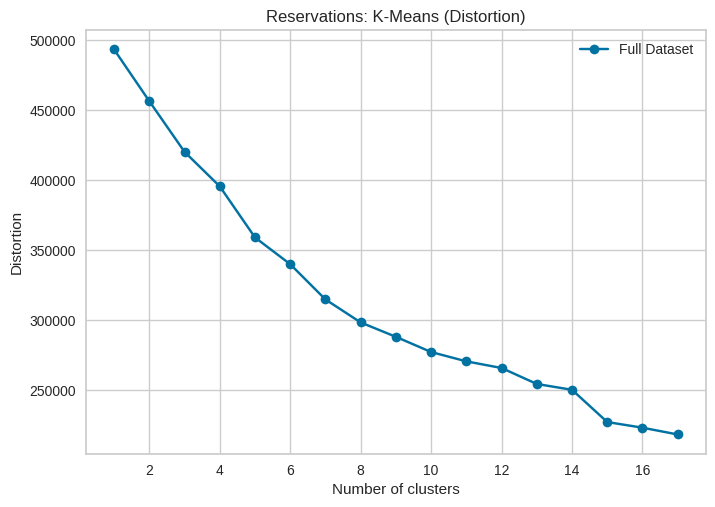

In [ ]:
plot_km("Reservations: K-Means (Distortion)", [x_train], ["Full Dataset"], k_range=range(1,18), metric="Distortion")
plt.show()

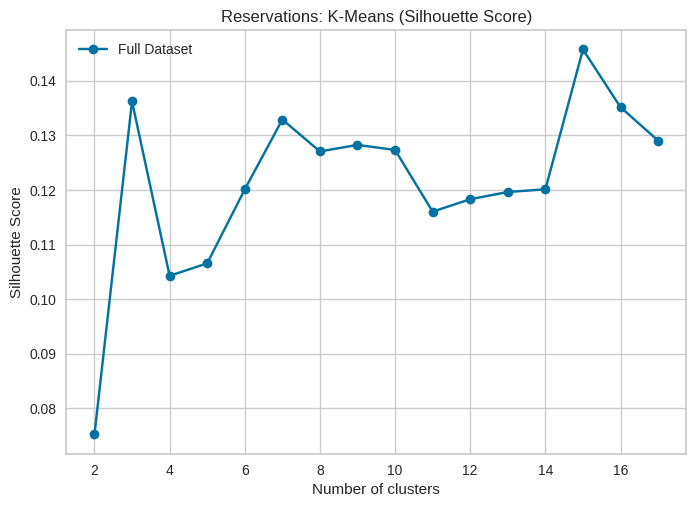

In [ ]:
plot_km("Reservations: K-Means (Silhouette Score)", [x_train],["Full Dataset"], k_range=range(2,18), metric="Silhouette Score")
plt.show()

In [22]:
km_model_2 = KMeans(n_clusters=2, n_init='auto', random_state=0)
km_model_2.fit(x_train)

km_model_3 = KMeans(n_clusters=3, n_init='auto', random_state=0)
km_model_3.fit(x_train)

km_model_7 = KMeans(n_clusters=7, n_init='auto', random_state=0)
km_model_7.fit(x_train)

km_model_15 = KMeans(n_clusters=15, n_init='auto', random_state=0)
km_model_15.fit(x_train)

km_x_train_2 = x_train.copy()
km_x_train_3 = x_train.copy()
km_x_train_7 = x_train.copy()
km_x_train_15 = x_train.copy()

km_x_train_2['cluster'] = km_model_2.predict(x_train)
km_x_train_3['cluster'] = km_model_3.predict(x_train)
km_x_train_7['cluster'] = km_model_7.predict(x_train)
km_x_train_15['cluster'] = km_model_15.predict(x_train)

km_x_test_2 = x_test.copy()
km_x_test_3 = x_test.copy()
km_x_test_7 = x_test.copy()
km_x_test_15 = x_test.copy()

km_x_test_2['cluster'] = km_model_2.predict(x_test)
km_x_test_3['cluster'] = km_model_3.predict(x_test)
km_x_test_7['cluster'] = km_model_7.predict(x_test)
km_x_test_15['cluster'] = km_model_15.predict(x_test)

km_test_datasets = [km_x_test_2, km_x_test_3, km_x_test_7, km_x_test_15]
km_datasets = [km_x_train_2, km_x_train_3, km_x_train_7, km_x_train_15]
km_dataset_labels = ["2 Clusters ", "3 Clusters", "7 Clusters", "15 Clusters"]

##Expectation Maximization

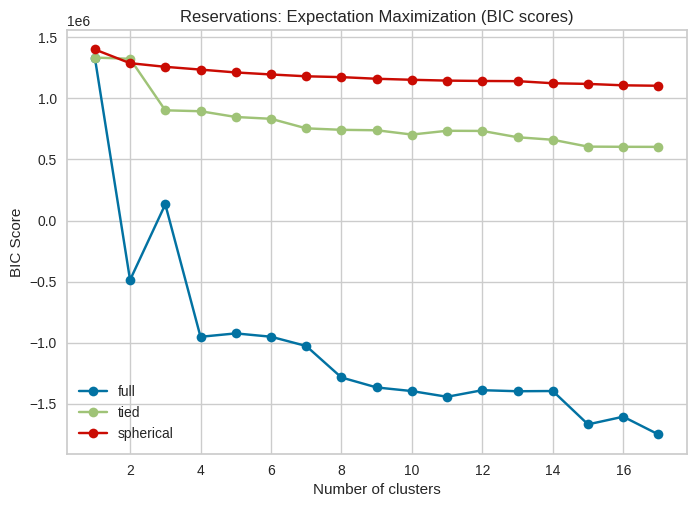

In [ ]:
plot_em_methods("Reservations: Expectation Maximization (BIC scores)", x_train, components_range=range(1,18))
plt.show()

In [34]:
em_model_2 = GaussianMixture(n_components=2, random_state=0, covariance_type='full')
em_model_2.fit(x_train)

em_model_4 = GaussianMixture(n_components=4, random_state=0, covariance_type='full')
em_model_4.fit(x_train)

em_model_8 = GaussianMixture(n_components=8, random_state=0, covariance_type='full')
em_model_8.fit(x_train)

em_model_15 = GaussianMixture(n_components=15, random_state=0, covariance_type='full')
em_model_15.fit(x_train)

em_x_train_2 = x_train.copy()
em_x_train_4 = x_train.copy()
em_x_train_8 = x_train.copy()
em_x_train_15 = x_train.copy()

em_x_train_2['cluster'] = em_model_2.predict(x_train)
em_x_train_4['cluster'] = em_model_4.predict(x_train)
em_x_train_8['cluster'] = em_model_8.predict(x_train)
em_x_train_15['cluster'] = em_model_15.predict(x_train)

em_x_test_2 = x_test.copy()
em_x_test_4 = x_test.copy()
em_x_test_8 = x_test.copy()
em_x_test_15 = x_test.copy()

em_x_test_2['cluster'] = em_model_2.predict(x_test)
em_x_test_4['cluster'] = em_model_4.predict(x_test)
em_x_test_8['cluster'] = em_model_8.predict(x_test)
em_x_test_15['cluster'] = em_model_15.predict(x_test)

em_test_datasets = [em_x_test_2, em_x_test_4, em_x_test_8, em_x_test_15]
em_datasets = [em_x_train_2, em_x_train_4, em_x_train_8, em_x_train_15]
em_dataset_labels = ["2 Clusters ", "4 Clusters", "8 Clusters", "15 Clusters"]

#Dimentionality Reduction

## Principal Component Analysis (PCA)

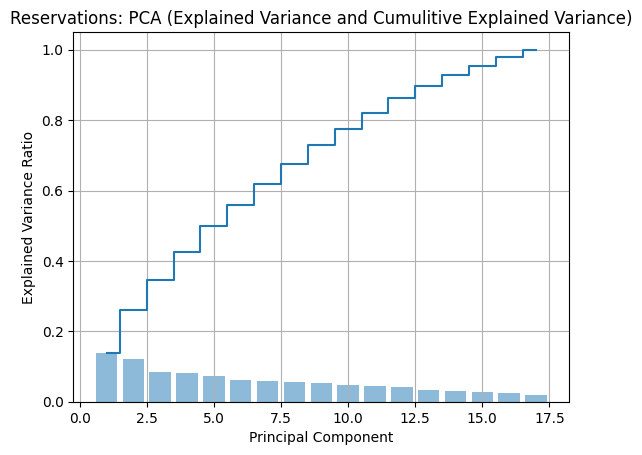

In [ ]:
plot_pca("Reservations: PCA (Explained Variance and Cumulitive Explained Variance)", x_train)
plt.show()

In [23]:
pca = PCA(n_components=17, random_state=0)

pca_x_train = pca.fit_transform(x_train)

pca_x_test = pca.transform(x_test)

pca_test_datasets = [pca_x_test[:,:3], pca_x_test[:,:6], pca_x_test[:,:11], pca_x_test[:,:16]]
pca_datasets = [pca_x_train[:,:3], pca_x_train[:,:6], pca_x_train[:,:11], pca_x_train[:,:16]]
pca_dataset_labels = ["2 Components ", "5 components", "10 components", "15 components"]

## Independent Component Analysis (ICA)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


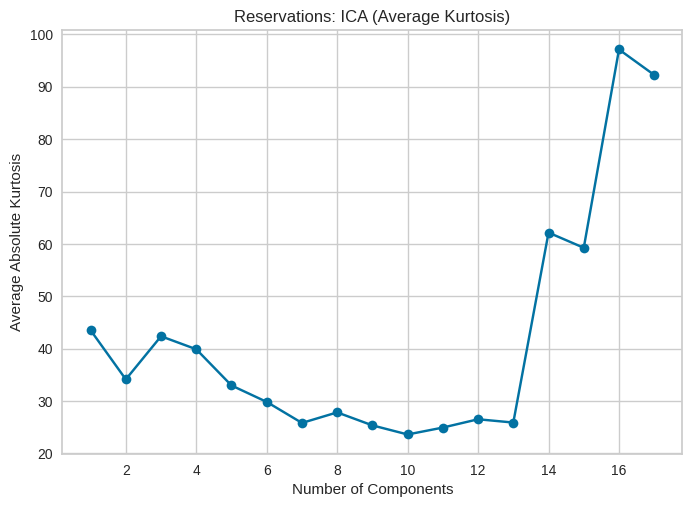

In [ ]:
plot_ica("Reservations: ICA (Average Kurtosis)", x_train)
plt.show()

In [54]:
ica_2 = FastICA(n_components=2, whiten='unit-variance', random_state=0)
ica_5 = FastICA(n_components=5, whiten='unit-variance', random_state=0)
ica_10 = FastICA(n_components=10, whiten='unit-variance', random_state=0)
ica_15 = FastICA(n_components=15, whiten='unit-variance', random_state=0)

ica_x_train_2 = ica_2.fit_transform(x_train)
ica_x_train_5 = ica_5.fit_transform(x_train)
ica_x_train_10 = ica_10.fit_transform(x_train)
ica_x_train_15 = ica_15.fit_transform(x_train)

ica_x_test_2 = ica_2.fit_transform(x_test)
ica_x_test_5 = ica_5.fit_transform(x_test)
ica_x_test_10 = ica_10.fit_transform(x_test)
ica_x_test_15 = ica_15.fit_transform(x_test)

ica_test_datasets = [ica_x_test_2, ica_x_test_5, ica_x_test_10, ica_x_test_15]
ica_datasets = [ica_x_train_2, ica_x_train_5, ica_x_train_10, ica_x_train_15]
ica_dataset_labels = ["2 Components ", "5 components", "10 components", "15 components"]

## Random Projection (RP)

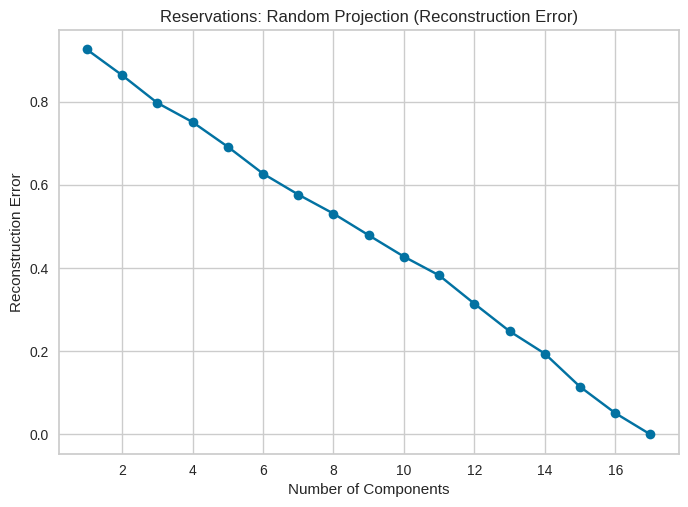

In [ ]:
plot_rp("Reservations: Random Projection (Reconstruction Error)", x_train)
plt.show()

In [57]:
rp_2 = GaussianRandomProjection(n_components=2, random_state=0)
rp_5 = GaussianRandomProjection(n_components=5, random_state=0)
rp_10 = GaussianRandomProjection(n_components=10, random_state=0)
rp_15 = GaussianRandomProjection(n_components=15, random_state=0)

rp_x_train_2 = rp_2.fit_transform(x_train)
rp_x_train_5 = rp_5.fit_transform(x_train)
rp_x_train_10 = rp_10.fit_transform(x_train)
rp_x_train_15 = rp_15.fit_transform(x_train)

rp_x_test_2 = rp_2.fit_transform(x_test)
rp_x_test_5 = rp_5.fit_transform(x_test)
rp_x_test_10 = rp_10.fit_transform(x_test)
rp_x_test_15 = rp_15.fit_transform(x_test)

rp_test_datasets = [rp_x_test_2, rp_x_test_5, rp_x_test_10, rp_x_test_15]
rp_datasets = [rp_x_train_2, rp_x_train_5, rp_x_train_10, rp_x_train_15]
rp_dataset_labels = ["2 Components ", "5 components", "10 components", "15 components"]

## Manifold Algorithm: t-SNE

In [22]:
tsne_2 = TSNE(n_components=2, random_state=0, learning_rate='auto')
tsne_3 = TSNE(n_components=3, random_state=0, learning_rate='auto')

tsne_x_train_2 = tsne_2.fit_transform(x_train)
tsne_x_train_3 = tsne_3.fit_transform(x_train)

tsne_x_test_2 = tsne_2.fit_transform(x_test)
tsne_x_test_3 = tsne_3.fit_transform(x_test)

tsne_test_datasets = [tsne_x_test_2, tsne_x_test_3]
tsne_datasets = [tsne_x_train_2, tsne_x_train_3]
tsne_dataset_labels = ["2 Components", "3 components"]

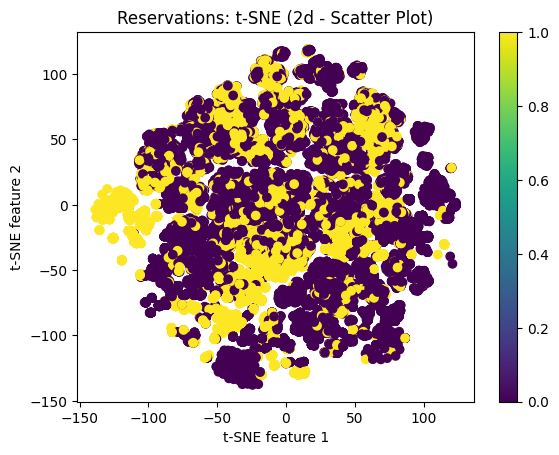

In [56]:
plot_tsne_2d("Reservations: t-SNE (2d - Scatter Plot)", tsne_x_train_2, y_train)
plt.show()

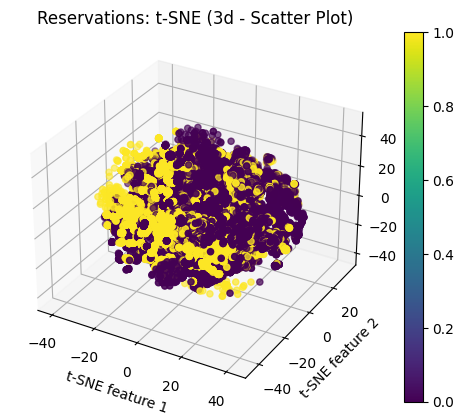

In [24]:
plot_tsne_3d("Reservations: t-SNE (3d - Scatter Plot)", tsne_x_train_3, y_train)
plt.show()

# Clustering - Dimentions Reduced

##K-Means

### Principal Component Analysis (PCA)

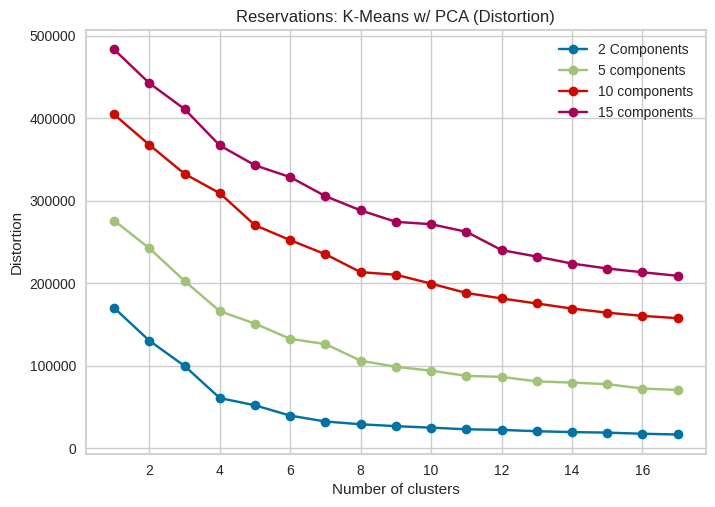

In [ ]:
plot_km("Reservations: K-Means w/ PCA (Distortion)", pca_datasets, pca_dataset_labels, k_range=range(1,18), metric="Distortion")
plt.show()

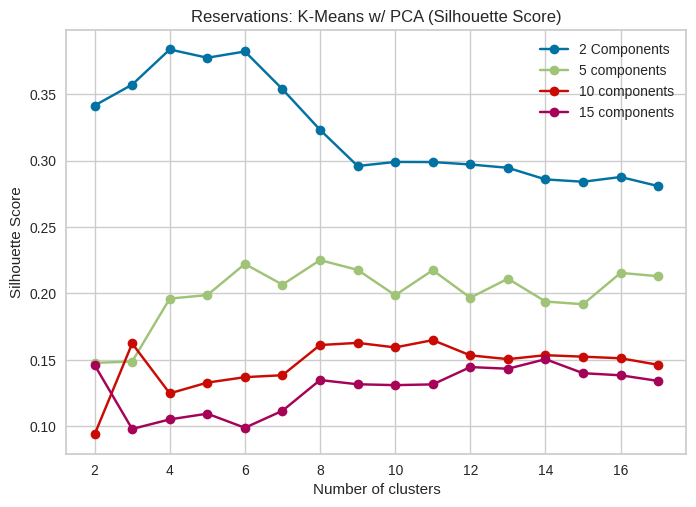

In [ ]:
plot_km("Reservations: K-Means w/ PCA (Silhouette Score)", pca_datasets, pca_dataset_labels, k_range=range(2,18), metric="Silhouette Score")
plt.show()

### Independent Component Analysis (ICA)

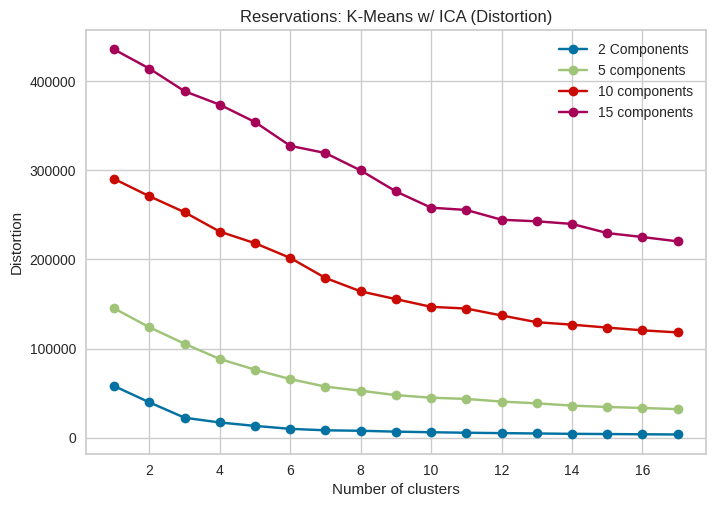

In [ ]:
plot_km("Reservations: K-Means w/ ICA (Distortion)", ica_datasets, ica_dataset_labels, k_range=range(1,18), metric="Distortion")
plt.show()

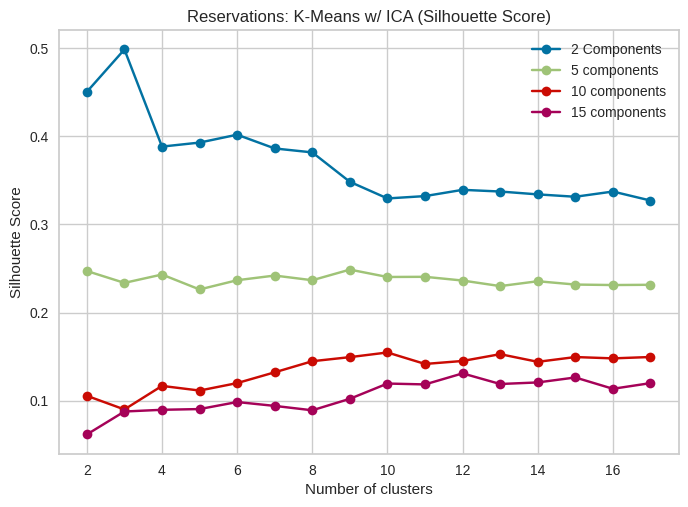

In [ ]:
plot_km("Reservations: K-Means w/ ICA (Silhouette Score)", ica_datasets, ica_dataset_labels, k_range=range(2,18), metric="Silhouette Score")
plt.show()

### Random Projection (RP)

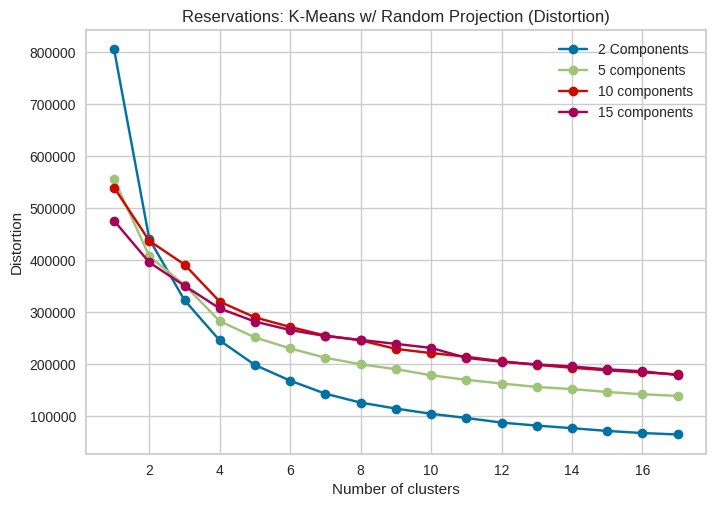

In [ ]:
plot_km("Reservations: K-Means w/ Random Projection (Distortion)", rp_datasets, rp_dataset_labels, k_range=range(1,18), metric="Distortion")
plt.show()

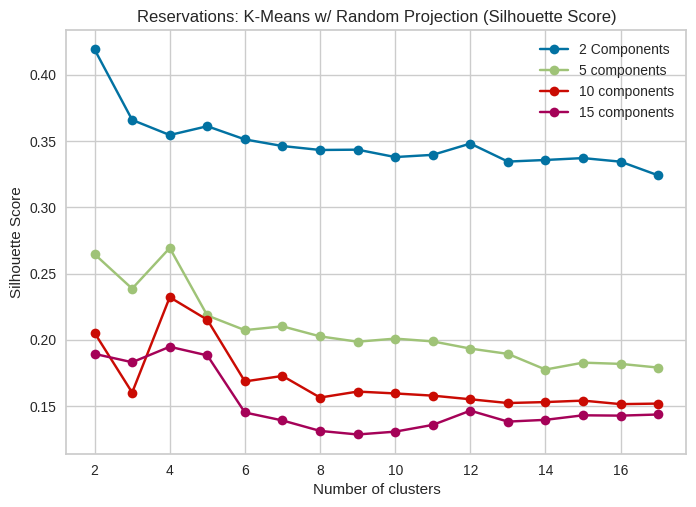

In [ ]:
plot_km("Reservations: K-Means w/ Random Projection (Silhouette Score)", rp_datasets, rp_dataset_labels, k_range=range(2,18), metric="Silhouette Score")
plt.show()

### Manifold Algorithm: t-SNE

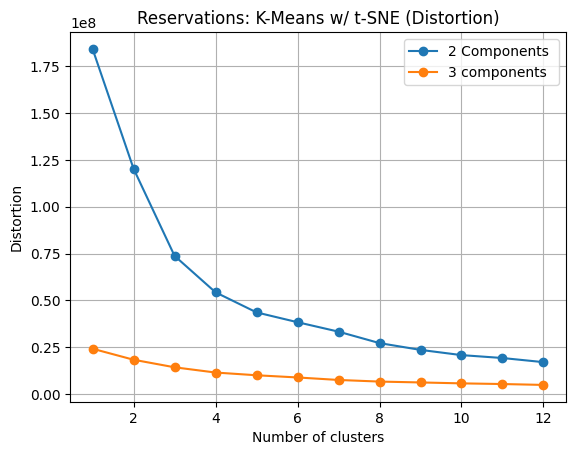

In [25]:
plot_km("Reservations: K-Means w/ t-SNE (Distortion)", tsne_datasets, tsne_dataset_labels, k_range=range(1,13), metric="Distortion")
plt.show()

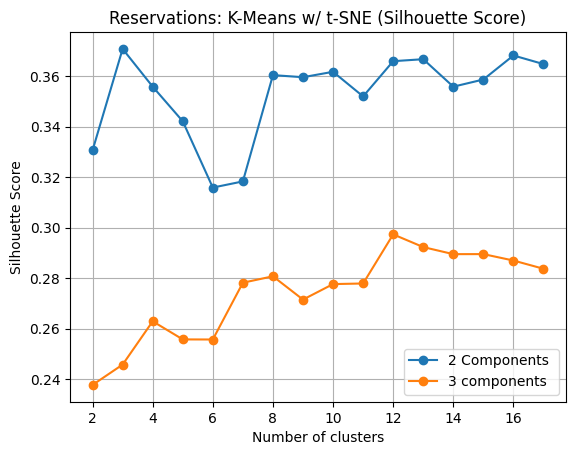

In [119]:
plot_km("Reservations: K-Means w/ t-SNE (Silhouette Score)", tsne_datasets, tsne_dataset_labels, k_range=range(2,18), metric="Silhouette Score")
plt.show()

##Expectation Maximization

### Principal Component Analysis (PCA)

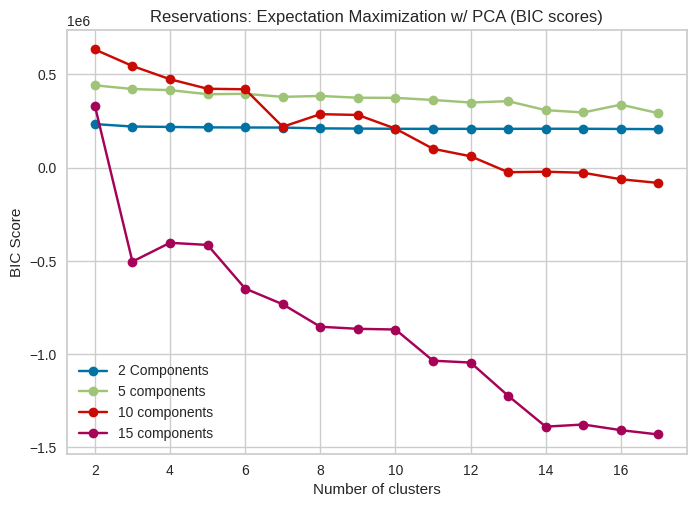

In [ ]:
plot_em("Reservations: Expectation Maximization -Full w/ PCA (BIC scores)", pca_datasets, pca_dataset_labels, components_range=range(1,18))
plt.show()

### Independent Component Analysis (ICA)

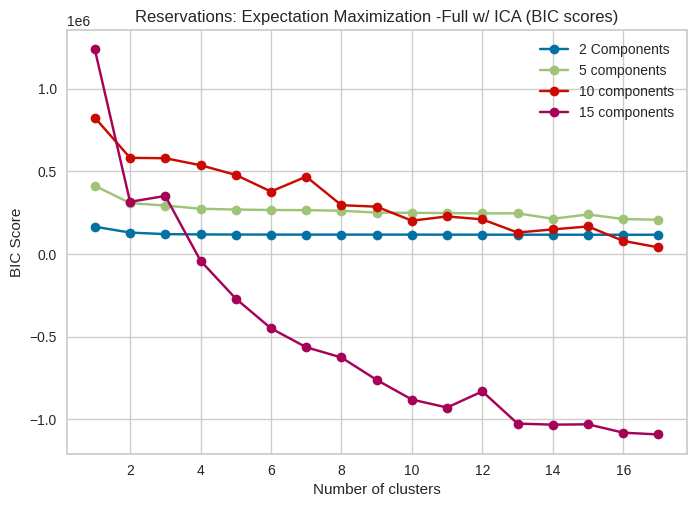

In [ ]:
plot_em("Reservations: Expectation Maximization -Full w/ ICA (BIC scores)", ica_datasets, ica_dataset_labels, components_range=range(1,18))
plt.show()

### Random Projection (RP)

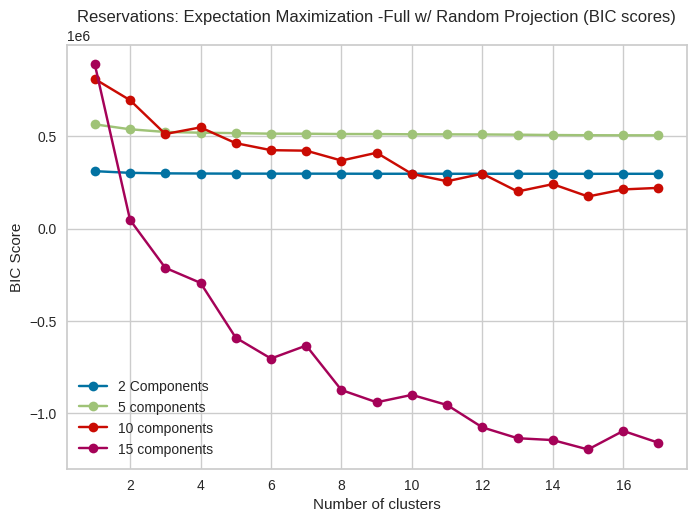

In [ ]:
plot_em("Reservations: Expectation Maximization -Full w/ Random Projection (BIC scores)", rp_datasets, rp_dataset_labels, components_range=range(1,18))
plt.show()

### Manifold Algorithm: t-SNE

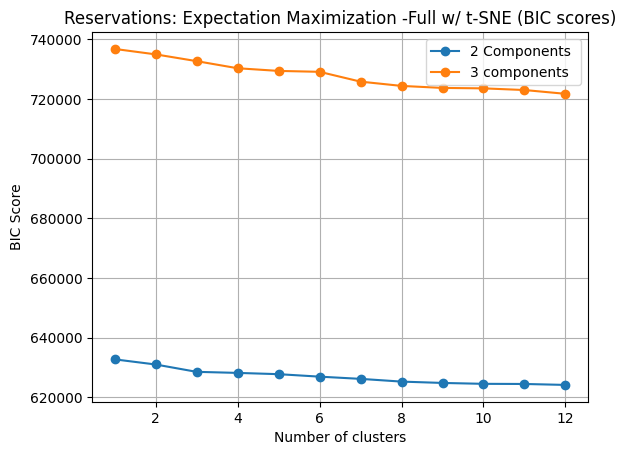

In [28]:
plot_em("Reservations: Expectation Maximization -Full w/ t-SNE (BIC scores)", tsne_datasets, tsne_dataset_labels, components_range=range(1,13))
plt.show()

#Neural Network


## After Dimentionality Reduction

### Principal Component Analysis (PCA)

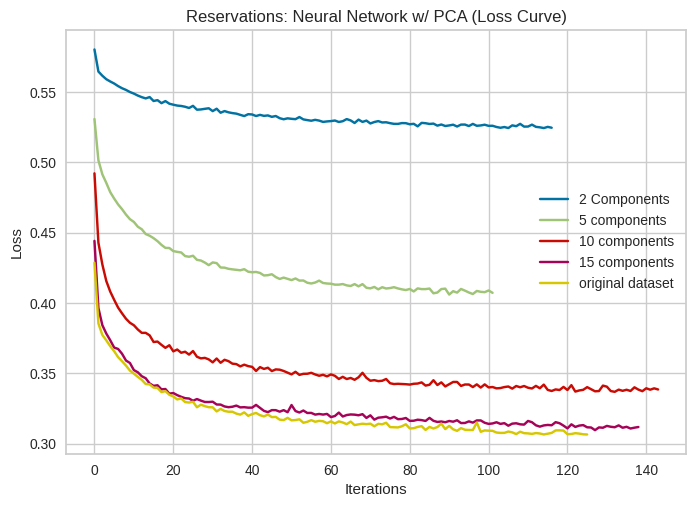

In [ ]:
plot_loss_curve("Reservations: Neural Network w/ PCA (Loss Curve)", pca_datasets+[x_train], pca_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

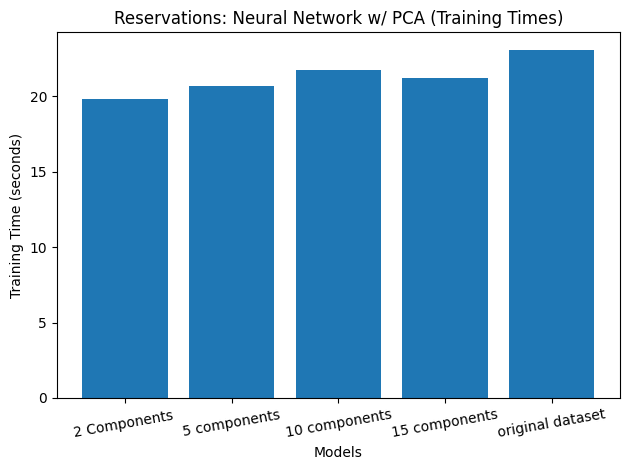

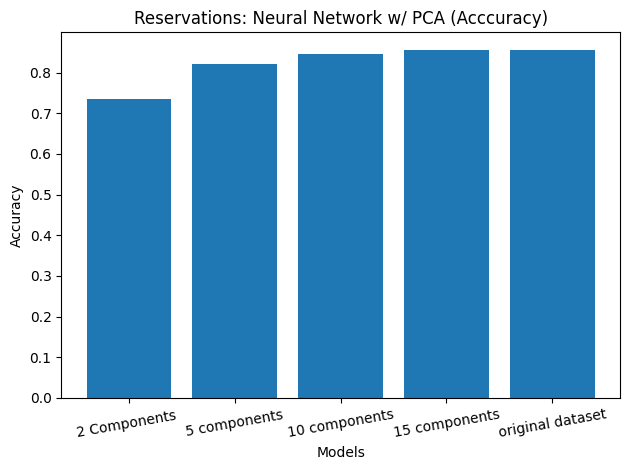

In [91]:
compare_models("Reservations: Neural Network w/ PCA (Training Times)", "Reservations: Neural Network w/ PCA (Acccuracy)", pca_datasets+[x_train], pca_test_datasets+[x_test], pca_dataset_labels+["original dataset"], y_train, y_test)

### Independent Component Analysis (ICA)

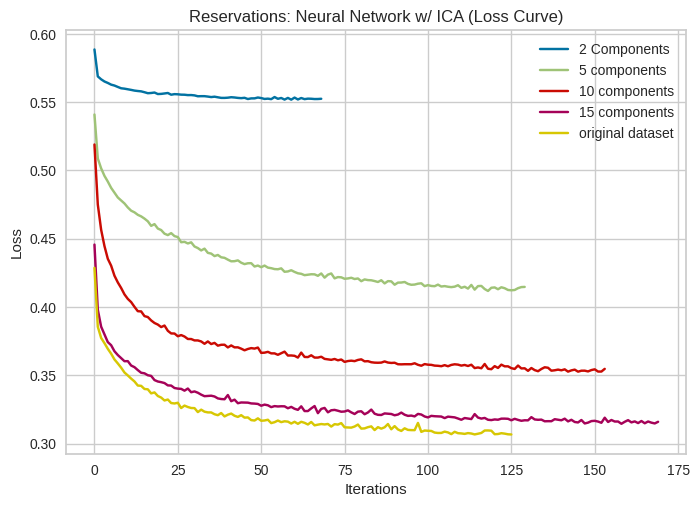

In [ ]:
plot_loss_curve("Reservations: Neural Network w/ ICA (Loss Curve)", ica_datasets+[x_train], ica_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

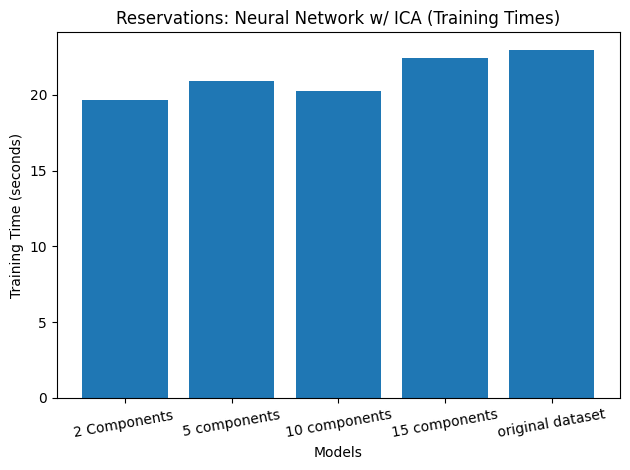

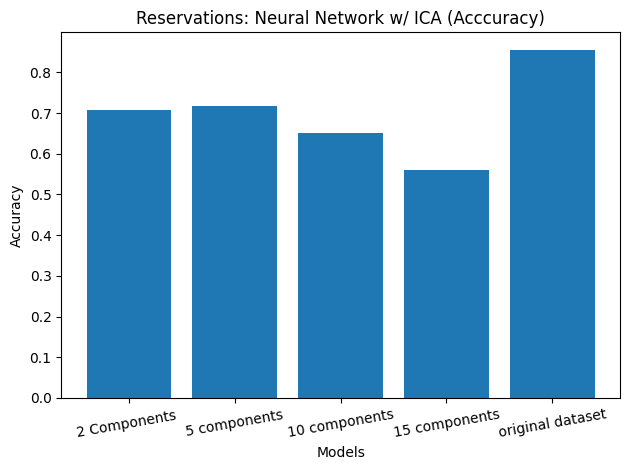

In [92]:
compare_models("Reservations: Neural Network w/ ICA (Training Times)", "Reservations: Neural Network w/ ICA (Acccuracy)", ica_datasets+[x_train], ica_test_datasets+[x_test], ica_dataset_labels+["original dataset"], y_train, y_test)

### Random Projection (RP)

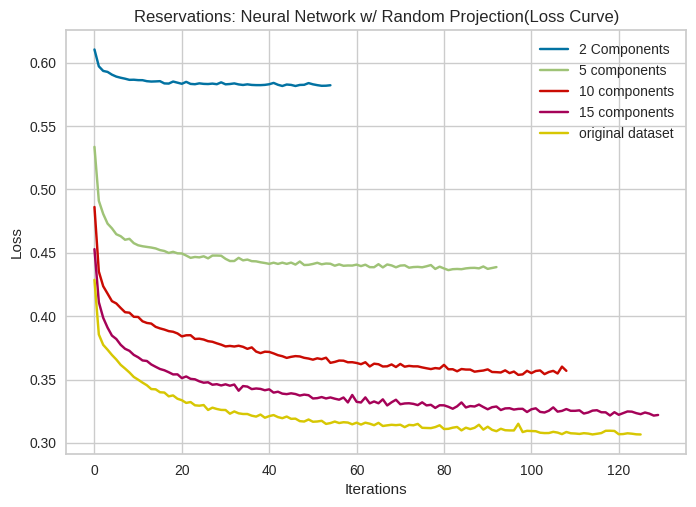

In [ ]:
plot_loss_curve("Reservations: Neural Network w/ Random Projection(Loss Curve)", rp_datasets+[x_train], rp_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

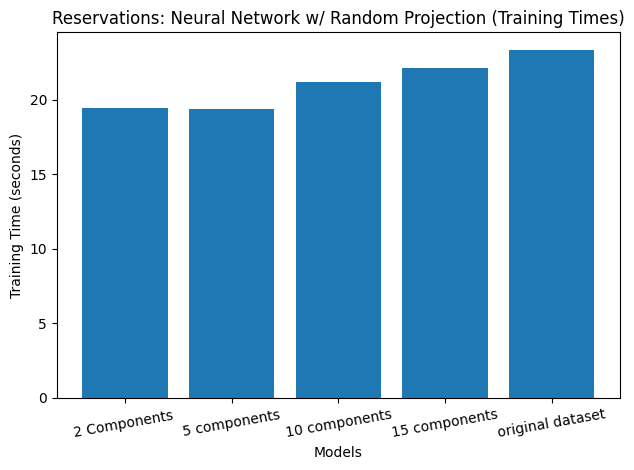

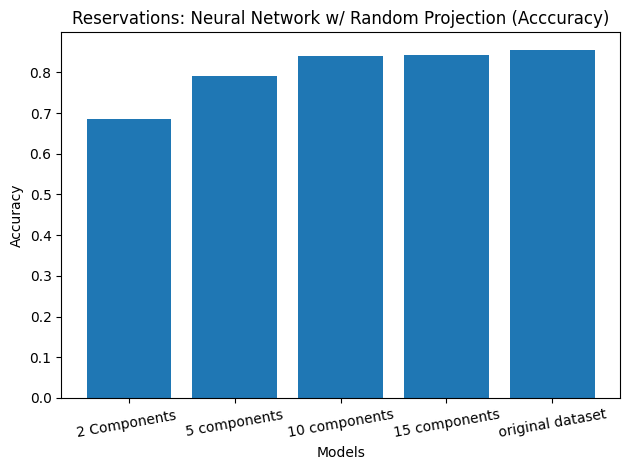

In [93]:
compare_models("Reservations: Neural Network w/ Random Projection (Training Times)", "Reservations: Neural Network w/ Random Projection (Acccuracy)", rp_datasets+[x_train], rp_test_datasets+[x_test], rp_dataset_labels+["original dataset"], y_train, y_test)

### Manifold Algorithm: t-SNE

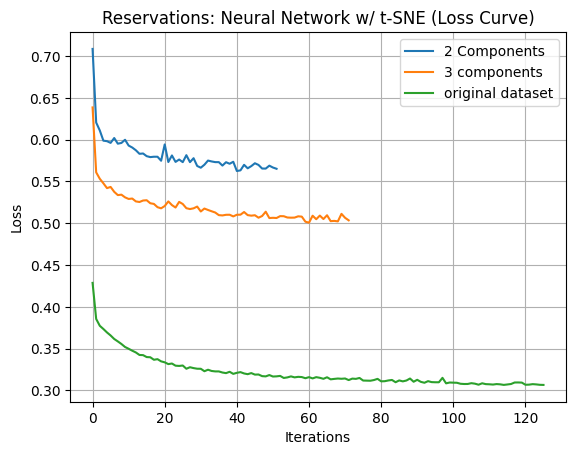

In [27]:
plot_loss_curve("Reservations: Neural Network w/ t-SNE (Loss Curve)", tsne_datasets+[x_train], tsne_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


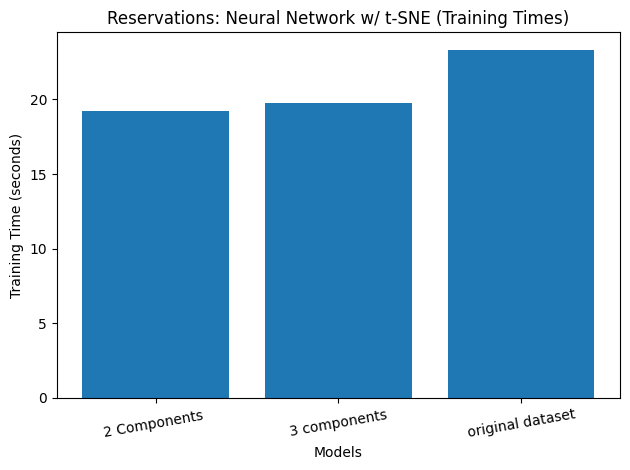

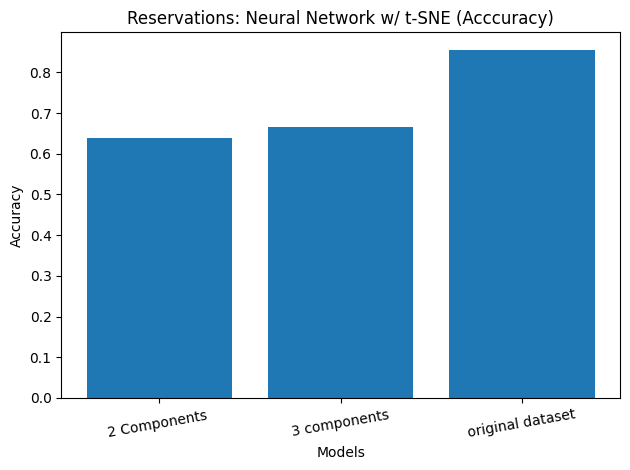

In [94]:
compare_models("Reservations: Neural Network w/ t-SNE (Training Times)", "Reservations: Neural Network w/ t-SNE (Acccuracy)", tsne_datasets+[x_train], tsne_test_datasets+[x_test], tsne_dataset_labels+["original dataset"], y_train, y_test)

## With Clustering Info

### Original Dataset

#### K-means

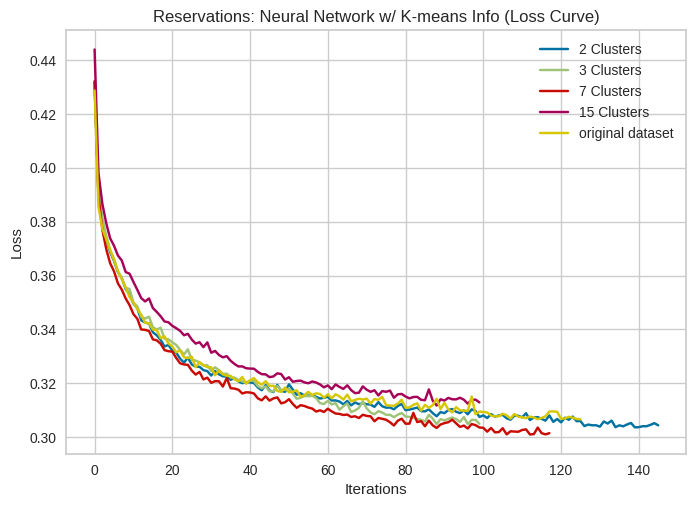

In [ ]:
plot_loss_curve("Reservations: Neural Network w/ K-means Info (Loss Curve)", km_datasets+[x_train], km_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

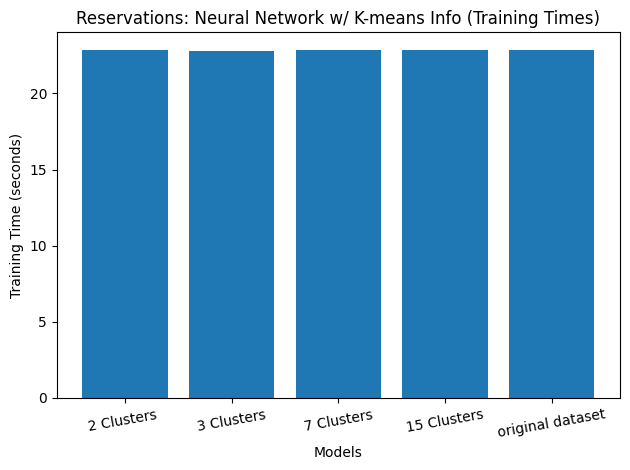

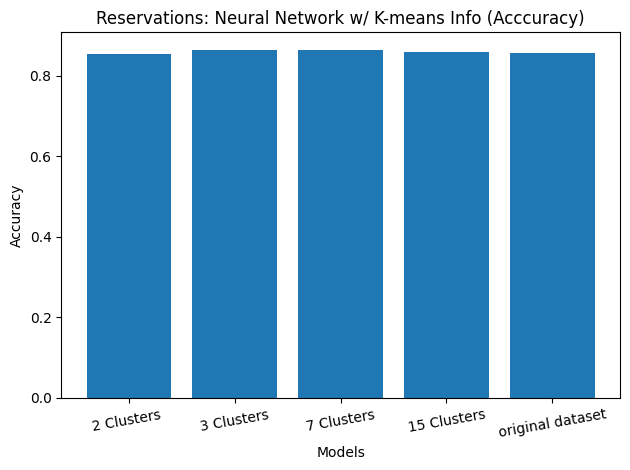

In [95]:
compare_models("Reservations: Neural Network w/ K-means Info (Training Times)", "Reservations: Neural Network w/ K-means Info (Acccuracy)", km_datasets+[x_train], km_test_datasets+[x_test], km_dataset_labels+["original dataset"], y_train, y_test)

#### Expectation Maximization

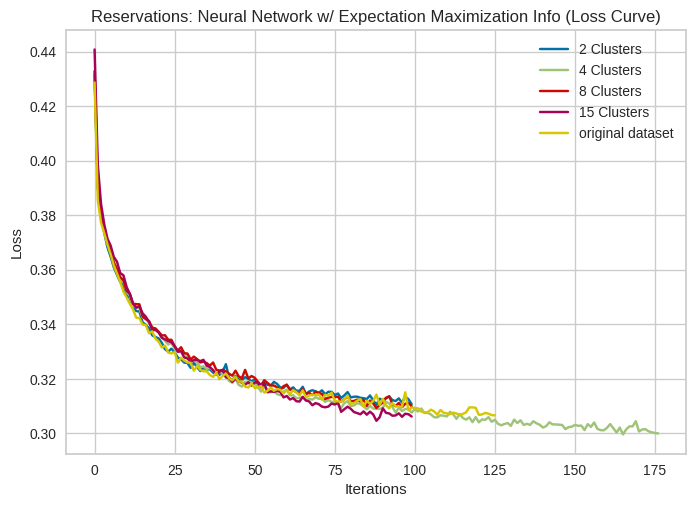

In [ ]:
plot_loss_curve("Reservations: Neural Network w/ Expectation Maximization Info (Loss Curve)", em_datasets+[x_train], em_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

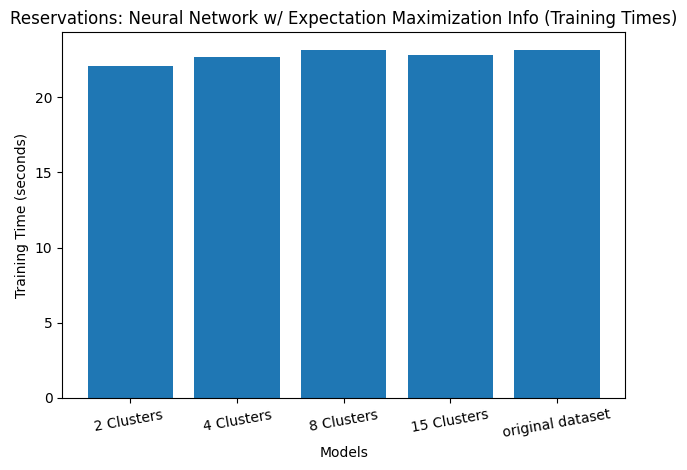

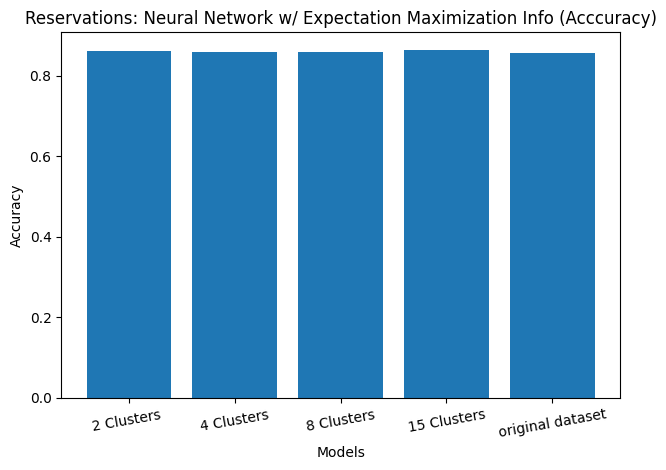

In [96]:
compare_models("Reservations: Neural Network w/ Expectation Maximization Info (Training Times)", "Reservations: Neural Network w/ Expectation Maximization Info (Acccuracy)", em_datasets+[x_train], em_test_datasets+[x_test], em_dataset_labels+["original dataset"], y_train, y_test)

### PCA Dataset

#### K-means

In [27]:
km_pca_test_datasets = [pca_x_test[:,:3].copy(), pca_x_test[:,:6].copy(), pca_x_test[:,:11].copy(), pca_x_test[:,:16].copy()]
km_pca_datasets = [pca_x_train[:,:3].copy(), pca_x_train[:,:6].copy(), pca_x_train[:,:11].copy(), pca_x_train[:,:16].copy()]
km_pca_dataset_labels = ["2 Components ", "5 components", "10 components", "15 components"]

km_pca_test_datasets[0] = np.append(km_pca_test_datasets[0], np.reshape(km_x_test_3['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
km_pca_test_datasets[1] = np.append(km_pca_test_datasets[1], np.reshape(km_x_test_3['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
km_pca_test_datasets[2] = np.append(km_pca_test_datasets[2], np.reshape(km_x_test_3['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
km_pca_test_datasets[3] = np.append(km_pca_test_datasets[3], np.reshape(km_x_test_3['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)

km_pca_datasets[0] = np.append(km_pca_datasets[0], np.reshape(km_x_train_3['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
km_pca_datasets[1] = np.append(km_pca_datasets[1], np.reshape(km_x_train_3['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
km_pca_datasets[2] = np.append(km_pca_datasets[2], np.reshape(km_x_train_3['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
km_pca_datasets[3] = np.append(km_pca_datasets[3], np.reshape(km_x_train_3['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)

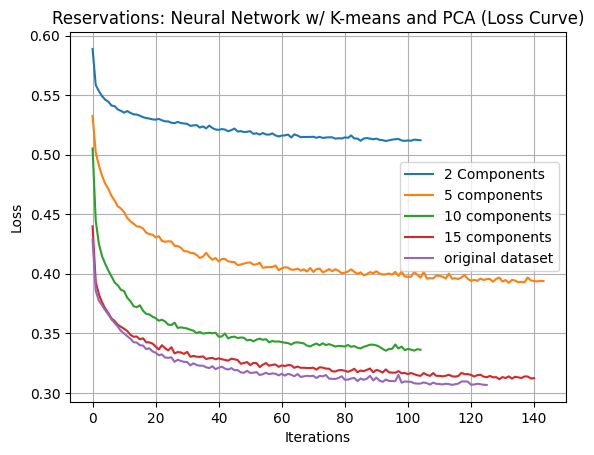

In [31]:
plot_loss_curve("Reservations: Neural Network w/ K-means and PCA (Loss Curve)", km_pca_datasets+[x_train], km_pca_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

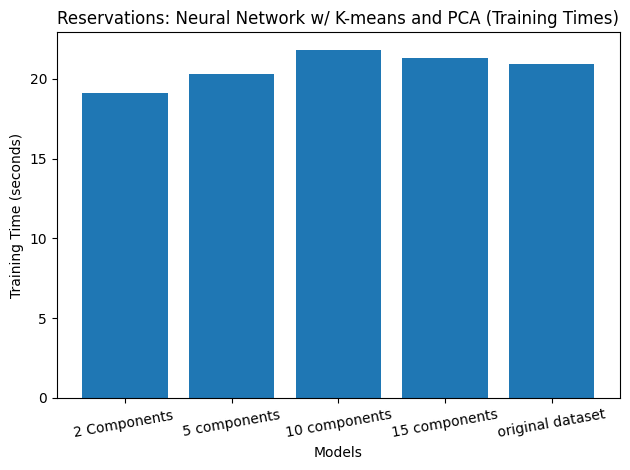

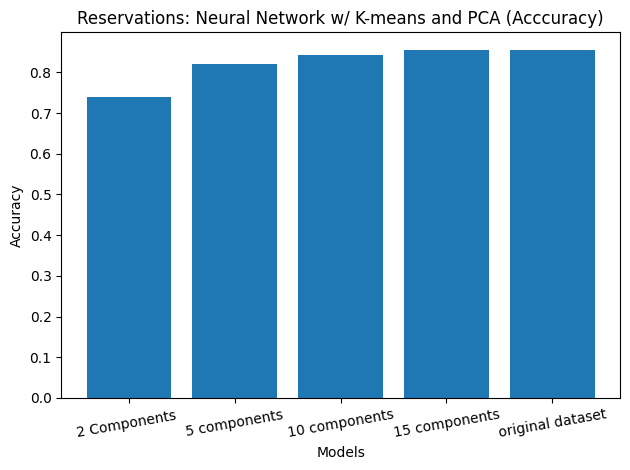

In [32]:
compare_models("Reservations: Neural Network w/ K-means and PCA (Training Times)", "Reservations: Neural Network w/ K-means and PCA (Acccuracy)", km_pca_datasets+[x_train], km_pca_test_datasets+[x_test], km_pca_dataset_labels+["original dataset"], y_train, y_test)

#### Expectation Maximization

In [35]:
em_pca_test_datasets = [pca_x_test[:,:3].copy(), pca_x_test[:,:6].copy(), pca_x_test[:,:11].copy(), pca_x_test[:,:16].copy()]
em_pca_datasets = [pca_x_train[:,:3].copy(), pca_x_train[:,:6].copy(), pca_x_train[:,:11].copy(), pca_x_train[:,:16].copy()]
em_pca_dataset_labels = ["2 Components ", "5 components", "10 components", "15 components"]

em_pca_test_datasets[0] = np.append(km_pca_test_datasets[0], np.reshape(em_x_test_4['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
em_pca_test_datasets[1] = np.append(km_pca_test_datasets[1], np.reshape(em_x_test_4['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
em_pca_test_datasets[2] = np.append(km_pca_test_datasets[2], np.reshape(em_x_test_4['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)
em_pca_test_datasets[3] = np.append(km_pca_test_datasets[3], np.reshape(em_x_test_4['cluster'].to_numpy(), newshape=(7255,-1)), axis=1)

em_pca_datasets[0] = np.append(km_pca_datasets[0], np.reshape(em_x_train_4['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
em_pca_datasets[1] = np.append(km_pca_datasets[1], np.reshape(em_x_train_4['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
em_pca_datasets[2] = np.append(km_pca_datasets[2], np.reshape(em_x_train_4['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)
em_pca_datasets[3] = np.append(km_pca_datasets[3], np.reshape(em_x_train_4['cluster'].to_numpy(), newshape=(29020,-1)), axis=1)

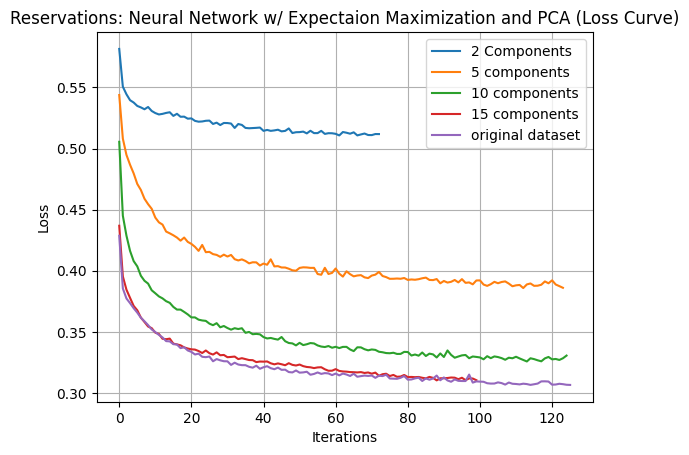

In [36]:
plot_loss_curve("Reservations: Neural Network w/ Expectaion Maximization and PCA (Loss Curve)", em_pca_datasets+[x_train], em_pca_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

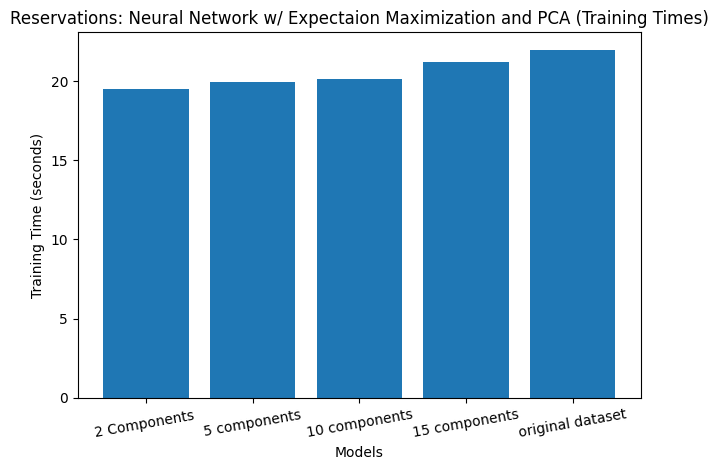

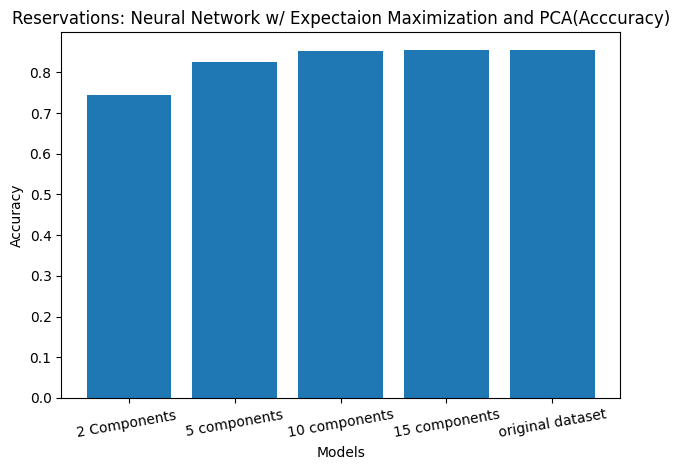

In [37]:
compare_models("Reservations: Neural Network w/ Expectaion Maximization and PCA (Training Times)", "Reservations: Neural Network w/ Expectaion Maximization and PCA(Acccuracy)", em_pca_datasets+[x_train], em_pca_test_datasets+[x_test], em_pca_dataset_labels+["original dataset"], y_train, y_test)